In [1]:
import pandas as pd
import numpy as np
from LDA_preprocessing import *
from sentiment_functions import *
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import CoherenceModel
%matplotlib inline

In [2]:
#Load the data set

# Need to split it in train, test und validation data
data_raw = pd.read_csv("Data/tripadvisor_hotel_reviews.csv")
data_in = data_raw['Review']

In [31]:
coh_mat = pd.DataFrame(index=range(0,30),columns=['bi_gram','tri_gram'], dtype='float')
mod = ['bi_gram','tri_gram']
for i in mod:
    print(i)
    results = lda_processing(data_in, model = i)
    corpus = results['text_corpus']
    id2word = results['id2word']
    texts = results['data_output']
    

    for x in range(1, 30):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= x,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           decay = 0.7,
                                           per_word_topics=True)
        cm = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
        coh_mat[i][x] = cm.get_coherence()

bi_gram
tri_gram


In [51]:
coh_mat.to_json(r'C:\Users\unters1\Desktop\Projekt\NLP\Topic Analysis\Data\coh_mat.json')

In [44]:
coh_mat

,bi_gram,tri_gram
0,NaN,NaN
1,0.303690,0.303072
2,0.358497,0.357283
3,0.362759,0.362718
4,0.363664,0.368953
5,0.399024,0.352234
6,0.388722,0.336201
7,0.422324,0.317033
8,0.384428,0.337746
9,0.367003,0.299822


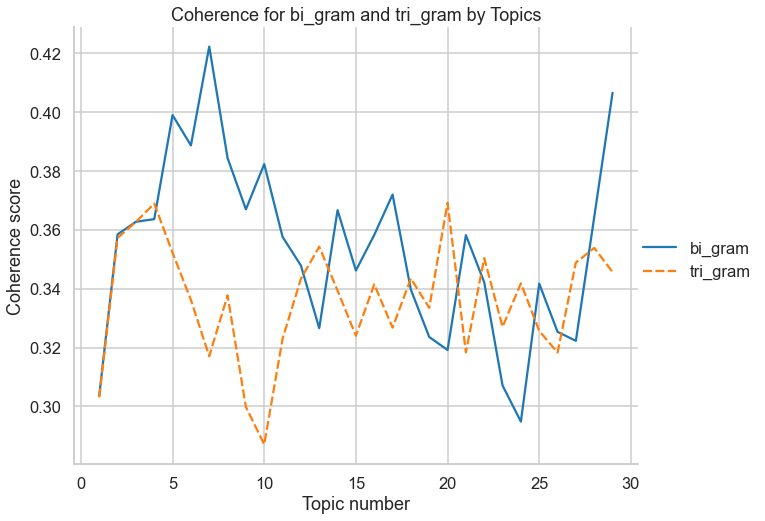

In [49]:
sns.relplot(data=coh_mat, kind="line", height=7, aspect=9/7)
sns.set_context("talk")
plt.title("Coherence for bi_gram and tri_gram by Topics")
plt.ylabel("Coherence score")
plt.xlabel("Topic number")
sns.set_style('whitegrid')

In [40]:
coh_mat['bi_gram'].idxmax()

7

In [3]:
results = lda_processing(data_in, model = 'bi_gram')
corpus = results['text_corpus']
id2word = results['id2word']
texts = results['data_output']

In [4]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= 7,# coh_mat['bi_gram'].idxmax(),
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           decay = 0.7,
                                           per_word_topics=True)

In [27]:
# Save model
from gensim.test.utils import datapath
lda_model.save("LDA_Model/model")

# Load a potentially pretrained model from disk.
#lda = LdaModel.load(temp_file)

In [5]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.251257  0.125537       1        1  31.582406
1     -0.210264 -0.092525       2        1  26.222232
0     -0.214608 -0.034670       3        1  24.665685
3      0.116644  0.103327       4        1   5.876155
4      0.173161  0.128443       5        1   4.960475
5      0.222447  0.137658       6        1   3.349991
2      0.163876 -0.367770       7        1   3.343057, topic_info=          Term          Freq         Total Category  logprob  loglift
22       hotel  44746.000000  44746.000000  Default  30.0000  30.0000
846       pool   6878.000000   6878.000000  Default  29.0000  29.0000
46        room  46419.000000  46419.000000  Default  28.0000  28.0000
4012    resort   7186.000000   7186.000000  Default  27.0000  27.0000
50        stay  25588.000000  25588.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
117       know    292.018086   3447.004285   Topic7  -5.1947   0.9298
443   employee    229.155081    536.733487   Topic7  -5.4371   2.5472
931        let    250.017476   1357.293889   Topic7  -5.3500   1.7066
61         ask    244.510793   4340.310239   Topic7  -5.3723   0.5218
236       wait    240.426908   2860.798404   Topic7  -5.3891   0.9218

[457 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
286       4  0.998885  activity
1628      2  0.997021    advise
1094      1  0.705552   airport
1094      6  0.293852   airport
871       2  0.998886      alot
...     ...       ...       ...
2119      3  0.995060     worry
960       2  0.996816     would
664       1  0.015514      year
664       2  0.057138      year
664       3  0.927068      year

[791 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 1, 4, 5, 6, 3])

In [5]:
#Function to print all the topics
topics = []
for topic_id in range(lda_model.num_topics):
    topk = lda_model.show_topic(topic_id, 10)
    topk_words = [ w for w, _ in topk ]
    topics.append([topic_id, ' '.join([ w for w, _ in lda_model.show_topic(topic_id, 10)])])
    print('{}: {}'.format(topic_id, ' '.join(topk_words)))
topics = pd.DataFrame(topics, columns =['Topic_id', 'Topic_words'])

0: time day go good really people great get want place
1: room service check night book pay use ask give arrive
2: tell ground manager call finally say happen send lose waiter
3: resort beach food water restaurant buffet kid vacation good activity
4: bathroom shower bed tv light bath window small bedroom water
5: pool bar drink water swim beer play main towel sand
6: hotel stay room great good staff location breakfast clean nice


In [6]:
#Manual assignment of the topics
topics = pd.DataFrame(topics, columns =['Topic_id', 'Topic_words'])
topics['Topic_name'] =['Trip_Stay','Check-In','Complaint','Beach','Bathroom','Pool','Hotel_Room']
topics

,Topic_id,Topic_words,Topic_name
0,0,time day go good really people great get want ...,Trip_Stay
1,1,room service check night book pay use ask give...,Check-In
2,2,tell ground manager call finally say happen se...,Complaint
3,3,resort beach food water restaurant buffet kid ...,Beach
4,4,bathroom shower bed tv light bath window small...,Bathroom
5,5,pool bar drink water swim beer play main towel...,Pool
6,6,hotel stay room great good staff location brea...,Hotel_Room


In [7]:
# Adding the probable topics to the data
data_raw['most_probable_topic'] = data_raw['Review'].apply(lambda x: lda_get_topics(lda_model, x, topics, topic_order = 0))
data_raw['second_probable_topic'] = data_raw['Review'].apply(lambda x: lda_get_topics(lda_model, x, topics, topic_order = 1))
data_raw['third_probable_topic'] = data_raw['Review'].apply(lambda x: lda_get_topics(lda_model, x, topics, topic_order = 2))

In [186]:
#Saving the data
data_raw.to_json(r'C:\Users\unters1\Desktop\Projekt\NLP\Topic Analysis\Data\reviews_add_tops.json')

In [8]:
data_raw.groupby("most_probable_topic").count()/len(data_raw)*100

,Review,Rating,second_probable_topic,third_probable_topic
most_probable_topic,,,,
Bathroom,0.082963,0.082963,0.082963,0.082963
Beach,0.278171,0.278171,0.278171,0.278171
Check-In,13.527890,13.527890,13.527890,13.527890
Complaint,0.024401,0.024401,0.024401,0.024401
Hotel_Room,70.396760,70.396760,70.396760,70.396760
Pool,0.009760,0.009760,0.009760,0.009760
Trip_Stay,15.680055,15.680055,15.680055,15.680055


In [9]:
data_raw.groupby("second_probable_topic").count()/len(data_raw)*100

,Review,Rating,most_probable_topic,third_probable_topic
second_probable_topic,,,,
Bathroom,0.712508,0.712508,0.712508,0.712508
Beach,2.279049,2.279049,2.279049,2.279049
Check-In,44.507345,44.507345,44.507345,44.507345
Complaint,0.190327,0.190327,0.190327,0.190327
Hotel_Room,16.309599,16.309599,16.309599,16.309599
Pool,0.190327,0.190327,0.190327,0.190327
Trip_Stay,35.810844,35.810844,35.810844,35.810844


In [10]:
data_raw.groupby("third_probable_topic").count()/len(data_raw)*100

,Review,Rating,most_probable_topic,second_probable_topic
third_probable_topic,,,,
Bathroom,4.216485,4.216485,4.216485,4.216485
Beach,4.865551,4.865551,4.865551,4.865551
Check-In,37.933727,37.933727,37.933727,37.933727
Complaint,0.971158,0.971158,0.971158,0.971158
Hotel_Room,7.954712,7.954712,7.954712,7.954712
Pool,0.951637,0.951637,0.951637,0.951637
Trip_Stay,43.106730,43.106730,43.106730,43.106730
